In [289]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import pickle
import seaborn as sns; sns.set(style ='white', color_codes = True)

In [110]:
college = pd.read_csv('players_stats.csv', index_col = 0)
nba = pd.read_csv('player_data.csv', index_col = 0)

### Cleaning

In [410]:
len(nba)

4550

In [111]:
nba_2000 = nba[nba['year_start'] > 2000]

In [112]:
nba_2000 = nba_2000.reset_index()

In [113]:
list_of_nba = nba_2000['name'].tolist()

In [114]:
len(list_of_nba)

1324

In [115]:
college.shape

(31860, 27)

In [116]:
#drop rows with NaN values
college.dropna(inplace=True)

### Exploratory Data Analysis

In [117]:
college.head()

,name,height,weight,position,games_played,games_started,min_per,field_goal,field_attmps,field_pct,...,free_attmps,free_pct,assists,steals,blocks,points,off_reb,def_reb,total_reb,turnovers
0,Menghe a'Nyam,6-5,215,Forward,41,19,13.3,0.9,2.1,0.414,...,1.2,0.529,0.1,0.4,0.3,2.4,1.3,1.7,3.0,1.0
1,Jordan Aaberg,6-9,225,Forward,115,16,11.2,1.5,2.3,0.619,...,0.7,0.788,0.2,0.2,0.8,3.5,0.7,1.6,2.3,0.6
2,Karl Aaker,6-5,210,Forward,92,29,16.4,1.4,4.0,0.346,...,0.6,0.611,0.6,0.4,0.2,4.1,0.6,1.4,2.0,0.8
3,Mike Aaman,6-8,210,Forward,107,55,19.0,3.1,6.5,0.473,...,2.8,0.641,0.4,0.5,0.7,7.9,2.5,3.2,5.7,1.2
4,Carlton Aaron,6-9,322,Center,86,72,24.5,4.3,7.8,0.544,...,4.1,0.482,0.3,0.6,0.6,10.5,3.1,4.3,7.3,1.5


In [118]:
college[college['weight'] == '22l' ] = college[college['weight'] == '22l' ].replace('22l', '221')

In [119]:
college.shape

(28614, 27)

In [120]:
college['height'] = college['height'].str.replace('-','')

In [121]:
college['height'] = college['height'].astype('int64')

In [122]:
college['height'] = college['height'].apply(lambda x: int(str(x)[0]) * 12 + int(str(x)[1:]))

In [123]:
college['weight'] = college['weight'].astype('int64')

In [124]:
def CorrMtx(df, dropDuplicates = True):
    # Your dataset is already a correlation matrix.
    # If you have a dateset where you need to include the calculation
    # of a correlation matrix, just uncomment the line below:
    # df = df.corr()
    # Exclude duplicate correlations by masking uper right values
    if dropDuplicates:    
        mask = np.zeros_like(df, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
    # Set background color / chart style
    sns.set_style(style = 'white')
    # Set up  matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))
    # Add diverging colormap from red to blue
    cmap = sns.diverging_palette(250, 10, as_cmap=True)
    # Draw correlation plot with or without duplicates
    if dropDuplicates:
        sns.heatmap(df, mask=mask, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax)
    else:
        sns.heatmap(df, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax)

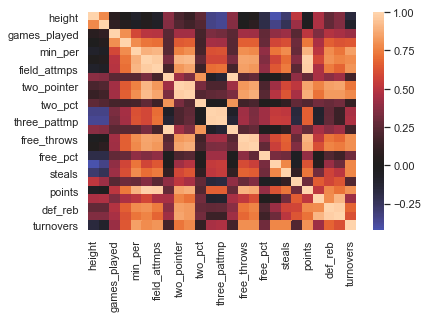

In [125]:
sns.heatmap(college.corr(), center=0)

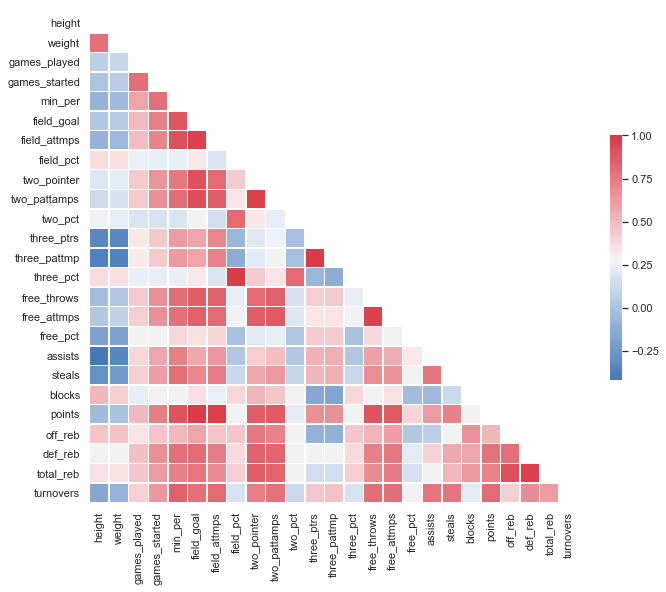

In [126]:
CorrMtx(college.corr(), dropDuplicates = True)

In [411]:
college.columns

Index(['name', 'height', 'weight', 'position', 'games_played', 'games_started',
       'min_per', 'field_goal', 'field_attmps', 'field_pct', 'two_pointer',
       'two_pattamps', 'two_pct', 'three_ptrs', 'three_pattmp', 'three_pct',
       'free_throws', 'free_attmps', 'free_pct', 'assists', 'steals', 'blocks',
       'points', 'off_reb', 'def_reb', 'total_reb', 'turnovers', 'drafted',
       'position_Center', 'position_Forward', 'position_Guard'],
      dtype='object')

In [127]:
college.describe()

,height,weight,games_played,games_started,min_per,field_goal,field_attmps,field_pct,two_pointer,two_pattamps,...,free_attmps,free_pct,assists,steals,blocks,points,off_reb,def_reb,total_reb,turnovers
count,28614.000000,28614.000000,28614.000000,28614.000000,28614.000000,28614.000000,28614.000000,28614.000000,28614.000000,28614.000000,...,28614.000000,28614.000000,28614.000000,28614.000000,28614.000000,28614.000000,28614.000000,28614.000000,28614.000000,28614.000000
mean,76.848571,204.535752,66.375481,32.687496,16.880101,1.993220,4.604725,0.418436,1.463654,3.041312,...,1.681086,0.644672,1.072307,0.549955,0.281233,5.658125,0.811337,1.846526,2.656315,1.146932
std,3.551681,26.156457,39.653458,34.481581,9.078075,1.485899,3.257786,0.109328,1.223640,2.355987,...,1.343829,0.166797,1.054711,0.429796,0.390007,4.248528,0.678038,1.243664,1.828479,0.741659
min,60.000000,101.000000,1.000000,0.000000,0.600000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,185.000000,31.000000,2.000000,9.200000,0.700000,1.900000,0.370000,0.500000,1.100000,...,0.600000,0.568000,0.300000,0.200000,0.000000,2.100000,0.300000,0.900000,1.300000,0.600000
50%,77.000000,200.000000,61.000000,22.000000,17.100000,1.700000,4.000000,0.419000,1.200000,2.500000,...,1.300000,0.667000,0.700000,0.500000,0.100000,4.800000,0.600000,1.700000,2.300000,1.000000
75%,80.000000,220.000000,103.000000,56.000000,24.300000,3.000000,6.800000,0.477000,2.200000,4.500000,...,2.400000,0.750000,1.500000,0.800000,0.400000,8.500000,1.200000,2.600000,3.700000,1.600000
max,91.000000,380.000000,157.000000,147.000000,38.600000,10.300000,21.900000,1.000000,10.100000,20.500000,...,9.800000,1.000000,8.700000,3.700000,5.400000,27.400000,5.500000,8.600000,12.700000,5.400000


In [130]:
with open("college_stats.pickle", "wb") as fp:
    pickle.dump(college, fp)

### Reload CSV - Checkpoint

In [131]:
college.to_csv(r'college_stats.csv')

In [151]:
college = pd.read_csv('college_stats.csv', index_col = 0)

In [152]:
college['drafted'] = college['name'].isin(list_of_nba).apply(lambda x: int(x))

In [153]:
positions = {"Guard": "Guard","Forward": "Forward","Center":"Center","Forward-Guard": "Forward","Guard-Forward": "Forward","Center-Forward":"Center",       
"Forward-Center":"Center","Guard-PG": "Guard","PGuard": "Guard","PGuard-G": "Guard","SForward":"Forward", "Forward-SF-Guard": "Forward", "PForward-F": "Forward",          
'Guard-SG': "Guard",'Forward-SF': "Forward",'PForward': "Forward",'Forward-PF': "Forward",'SForward-F': "Forward",'SGuard-G': "Guard"}


In [154]:
college['position'] = college['position'].apply(lambda x: positions[x])

In [155]:
college['position'].value_counts()

Guard      15157
Forward    10916
Center      2541
Name: position, dtype: int64

In [157]:
position = pd.get_dummies(college['position'],prefix='position')

In [158]:
college = college.merge(position, left_index = True, right_index = True,)

In [159]:
college.head()

,name,height,weight,position,games_played,games_started,min_per,field_goal,field_attmps,field_pct,...,blocks,points,off_reb,def_reb,total_reb,turnovers,drafted,position_Center,position_Forward,position_Guard
0,Menghe a'Nyam,77,215,Forward,41,19,13.3,0.9,2.1,0.414,...,0.3,2.4,1.3,1.7,3.0,1.0,0,0,1,0
1,Jordan Aaberg,81,225,Forward,115,16,11.2,1.5,2.3,0.619,...,0.8,3.5,0.7,1.6,2.3,0.6,0,0,1,0
2,Karl Aaker,77,210,Forward,92,29,16.4,1.4,4.0,0.346,...,0.2,4.1,0.6,1.4,2.0,0.8,0,0,1,0
3,Mike Aaman,80,210,Forward,107,55,19.0,3.1,6.5,0.473,...,0.7,7.9,2.5,3.2,5.7,1.2,0,0,1,0
4,Carlton Aaron,81,322,Center,86,72,24.5,4.3,7.8,0.544,...,0.6,10.5,3.1,4.3,7.3,1.5,0,1,0,0


#### Place 1 and 0 for Drafted - Not Drafted

In [430]:
college_players = college[college['games_played'] >= 5]

In [ ]:
not_drafted = college_players[college_players['drafted'] == 0]
len(not_drafted)

In [ ]:
sampled_n_drafted = not_drafted.sample(n = 2000)

In [ ]:
drafted = college_players[college_players['drafted'] == 1]
len(drafted)

In [ ]:
collegename = pd.concat([drafted, sampled_n_drafted])

In [ ]:
college_nba = pd.concat([drafted, sampled_n_drafted])

In [ ]:
college_noname = college_players.drop(['name','position'], axis= 1)

In [438]:
collegenames = collegename[['name']]

## Checkpoint Save to CSV

In [241]:
college_players.to_csv(r'stats/college_players_stats.csv')

In [243]:
drafted.to_csv(r'stats/drafted_players.csv')

In [244]:
not_drafted.to_csv(r'stats/not_drafted.csv')

In [252]:
college_noname.to_csv(r'stats/college_noname.csv')

In [440]:
collegenames.to_csv(r'stats/collegenames.csv')

In [254]:
college_nba = pd.read_csv('stats/college_noname.csv', index_col = 0)

In [206]:
def  draw_boxplots_non_drafted(var):
    f, ax = plt.subplots(figsize=(12, 6))
    fig = sns.boxplot(x=var, y="games_played", data=sampled_n_drafted)
    fig.axis(ymin=0, ymax=350)

In [285]:
def  draw_boxplots_drafted(var):
    f, ax = plt.subplots(figsize=(12, 6))
    fig = sns.boxplot(x=var, y="games_played", data=college_nba)
    fig.axis(ymin=0, ymax=350)

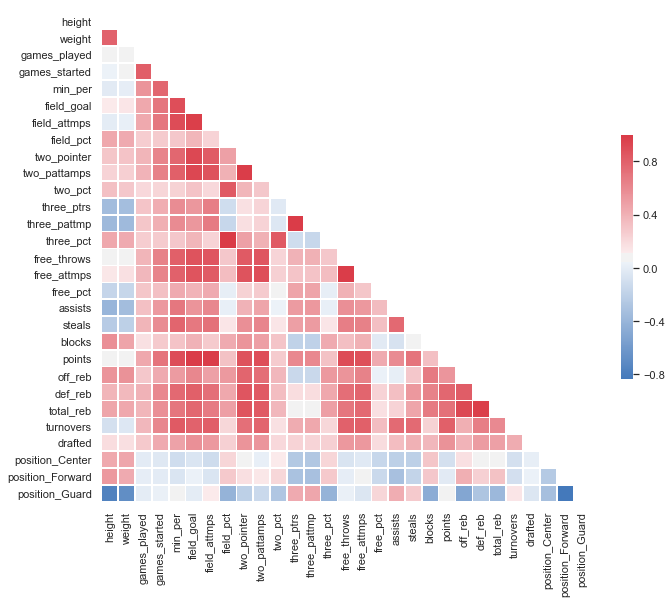

In [276]:
CorrMtx(college_nba.corr(), dropDuplicates = True)

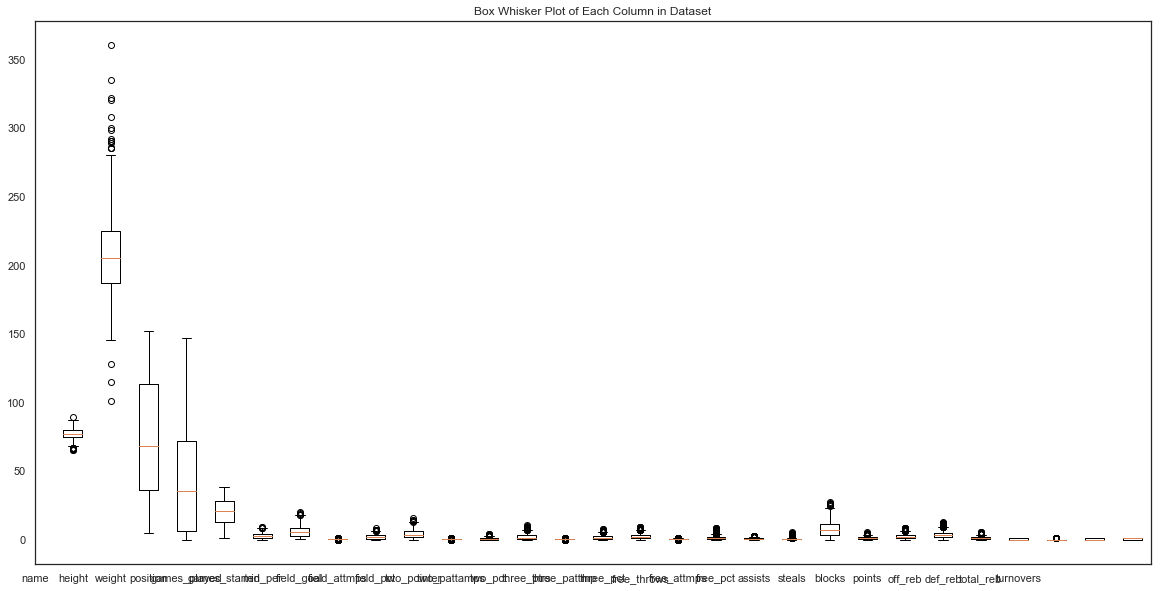

In [275]:
# Create a Box Whisker Plot of each column
plt.figure(figsize=(20, 10))
plt.boxplot([college_nba[col] for col in college_nba.columns])
plt.title("Box Whisker Plot of Each Column in Dataset")
plt.xticks(range(len(df.columns.values)), df.columns.values)
plt.show()

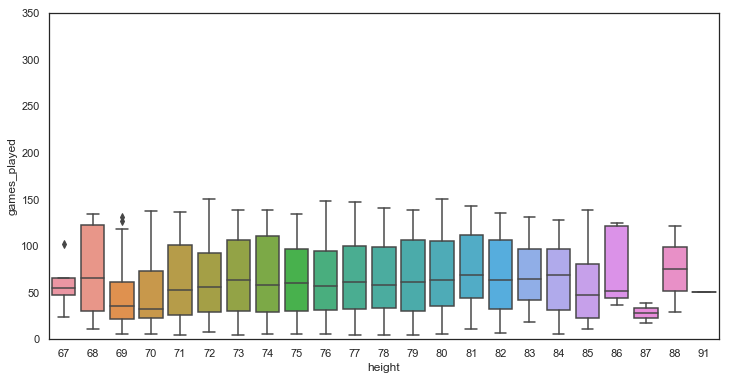

In [361]:
draw_boxplots_non_drafted('height')

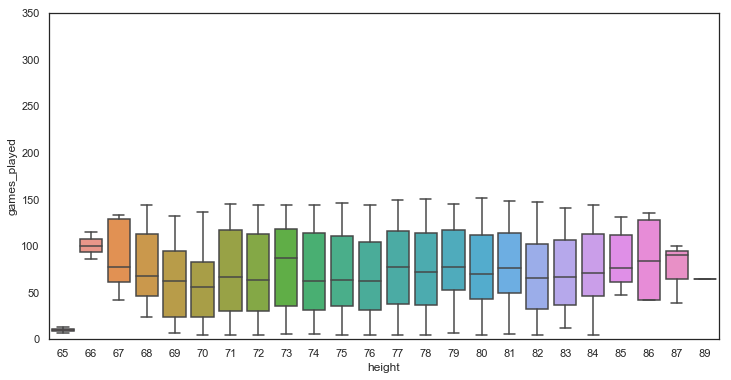

In [362]:
draw_boxplots_drafted('height')

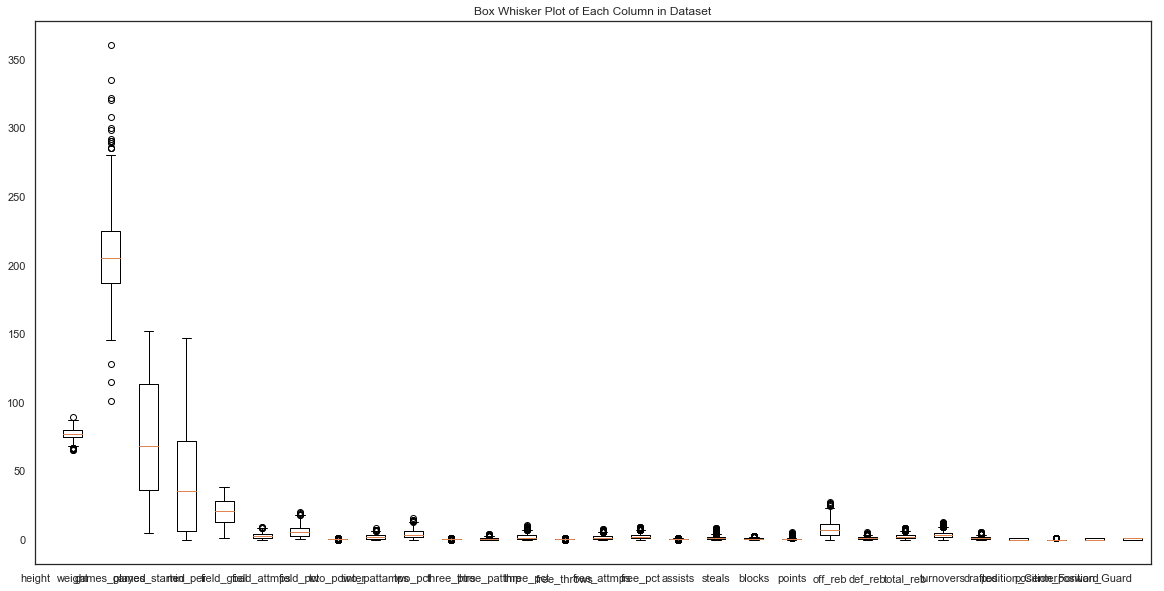

In [366]:
# Create a Box Whisker Plot of each column
plt.figure(figsize=(20, 10))
plt.boxplot([college_nba[col] for col in college_nba.columns])
plt.title("Box Whisker Plot of Each Column in Dataset")
plt.xticks(range(len(college_nba.columns.values)), college_nba.columns.values)
plt.show()

In [367]:
drafted.describe()

,height,weight,games_played,games_started,min_per,field_goal,field_attmps,field_pct,two_pointer,two_pattamps,...,blocks,points,off_reb,def_reb,total_reb,turnovers,drafted,position_Center,position_Forward,position_Guard
count,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,...,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.000000,1002.0,1002.000000,1002.000000,1002.000000
mean,78.169661,214.078842,90.513972,67.426148,26.242715,4.056287,8.615868,0.472238,3.196307,6.218463,...,0.715170,11.511677,1.506188,3.451796,4.955888,1.868762,1.0,0.093812,0.413174,0.493014
std,3.452425,26.145118,37.772497,36.578259,6.943177,1.553651,3.340138,0.070426,1.410308,2.586642,...,0.751801,4.519702,0.899462,1.474472,2.242272,0.762975,0.0,0.291713,0.492649,0.500201
min,68.000000,145.000000,5.000000,0.000000,1.200000,0.000000,0.100000,0.000000,0.000000,0.100000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000
25%,76.000000,195.000000,62.000000,37.000000,23.200000,3.200000,6.500000,0.430000,2.300000,4.625000,...,0.200000,8.800000,0.700000,2.500000,3.300000,1.400000,1.0,0.000000,0.000000,0.000000
50%,78.000000,214.000000,97.000000,67.500000,27.800000,4.200000,8.800000,0.463000,3.100000,6.100000,...,0.500000,11.900000,1.400000,3.300000,4.700000,1.900000,1.0,0.000000,0.000000,0.000000
75%,81.000000,234.750000,126.000000,97.000000,31.175000,5.100000,10.875000,0.517000,4.100000,8.000000,...,1.000000,14.600000,2.100000,4.300000,6.400000,2.300000,1.0,0.000000,1.000000,1.000000
max,89.000000,360.000000,152.000000,147.000000,38.200000,9.300000,20.400000,0.665000,8.200000,15.400000,...,5.400000,26.600000,5.500000,8.600000,12.700000,5.400000,1.0,1.000000,1.000000,1.000000


### Min_per and Points of Players Drafted And Not Drafted

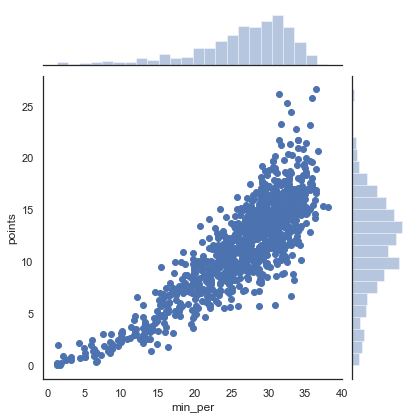

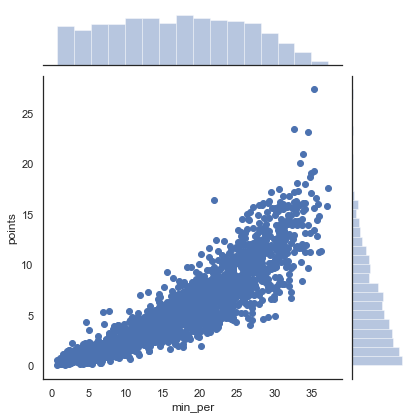

In [405]:
sns.jointplot(x= 'min_per', y = 'points', data=drafted)
sns.jointplot(x='min_per', y='points', data=sampled_n_drafted)

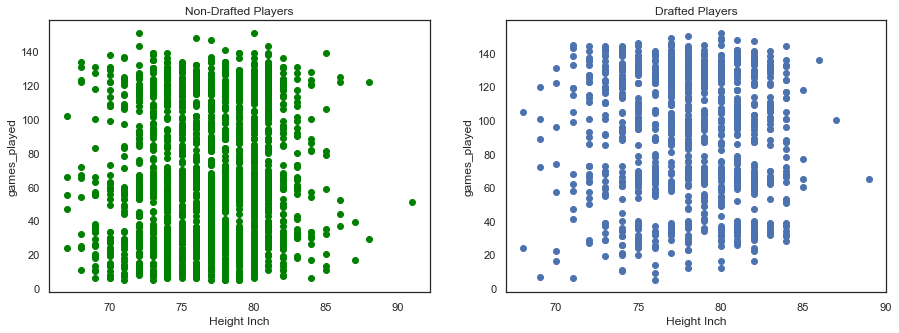

In [401]:
# Creates two subplots and unpacks the output array immediately
x_feature_n = sampled_n_drafted['height']
y_target_n = sampled_n_drafted['games_played']
x_feature_d = drafted['height']
y_target_d = drafted['games_played']
f, (ax1, ax2) = plt.subplots(1, 2, sharey= False, figsize= (15,5))
ax2.scatter(x_feature_d, y_target_d)
ax1.scatter(x_feature_n, y_target_n, c= 'green')
ax1.set(xlabel='Height Inch', ylabel='games_played',
       title='Non-Drafted Players')
ax2.set(xlabel='Height Inch', ylabel='games_played',
       title='Drafted Players')
plt.show()

### Games Played and Points of Players Drafted And Not Drafted

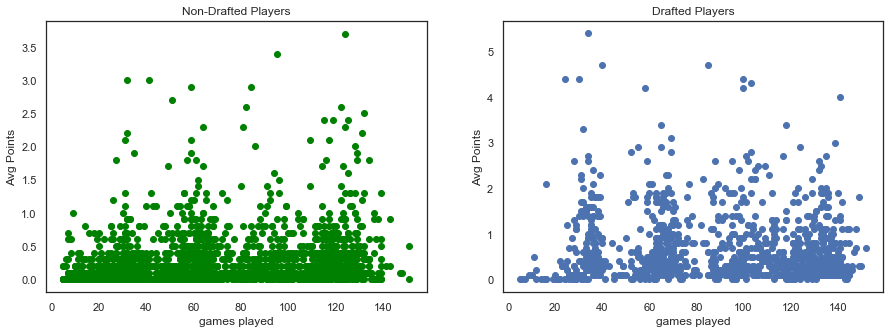

In [409]:
# Creates two subplots and unpacks the output array immediately
x_feature_gamesplayed_n = sampled_n_drafted['games_played']
y_target_gamesplayed_n = sampled_n_drafted['blocks']
x_feature_gamesplayed_d = drafted['games_played']
y_target_gamesplayed_d = drafted['blocks']
f, (ax1, ax2) = plt.subplots(1, 2, sharey= False, figsize= (15,5))
ax2.scatter(x_feature_gamesplayed_d, y_target_gamesplayed_d)
ax1.scatter(x_feature_gamesplayed_n, y_target_gamesplayed_n, c= 'green')
ax1.set(xlabel='games played', ylabel='Avg Points',
       title='Non-Drafted Players')
ax2.set(xlabel='games played', ylabel='Avg Points',
       title='Drafted Players')
plt.show()

### Games Played and Points of Players Drafted And Not Drafted

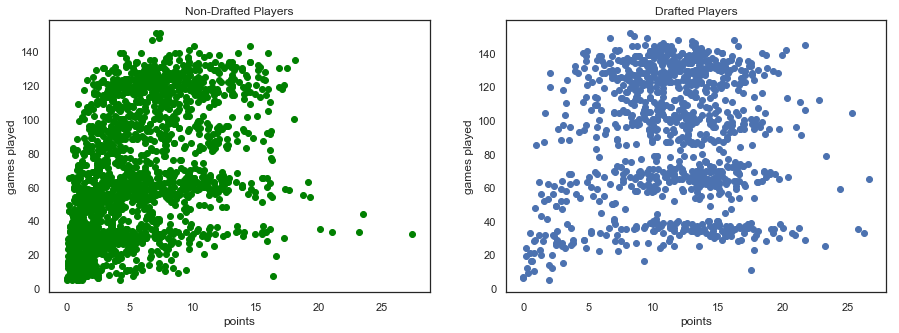

In [399]:
# Creates two subplots and unpacks the output array immediately
x_feature_weight_n = sampled_n_drafted['games_played']
y_target_weight_n = sampled_n_drafted['points']
x_feature_weight_d = drafted['games_played']
y_target_weight_d = drafted['points']


f, (ax1, ax2) = plt.subplots(1, 2, sharey= False, figsize= (15,5))

ax2.scatter(y_target_weight_d,x_feature_weight_d)

ax1.scatter(y_target_weight_n, x_feature_weight_n, c='green')

ax1.set(xlabel='points', ylabel='games played',
       title='Non-Drafted Players')

ax2.set(xlabel='points', ylabel='games played',
       title='Drafted Players')
plt.show()

### Games Started and Points of Players Drafted And Not Drafted

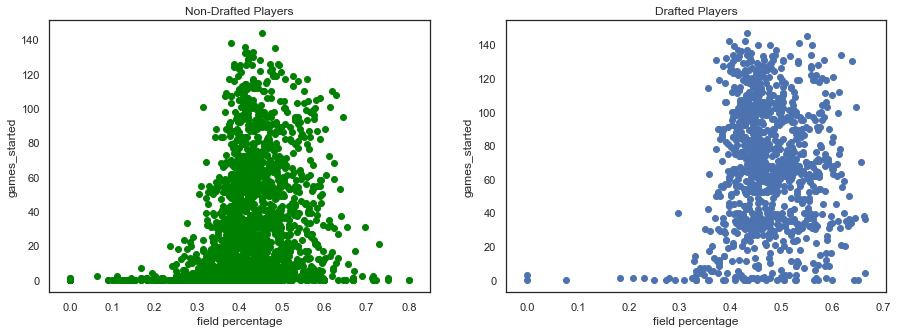

In [406]:
# Creates two subplots and unpacks the output array immediately
x_feature_gamesstarted_n = sampled_n_drafted['field_pct']
y_target_gamesstarted_n = sampled_n_drafted['games_started']
x_feature_gamesstarted_d = drafted['field_pct']
y_target_gamesstarted_d = drafted['games_started']
f, (ax1, ax2) = plt.subplots(1, 2, sharey= False, figsize= (15,5))
ax2.scatter(x_feature_gamesstarted_d, y_target_gamesstarted_d)
ax1.scatter(x_feature_gamesstarted_n, y_target_gamesstarted_n, c= 'green')
ax1.set(xlabel='field percentage', ylabel='games_started',
       title='Non-Drafted Players')
ax2.set(xlabel='field percentage', ylabel='games_started',
       title='Drafted Players')
plt.show()

In [339]:
college_nba.describe()

,height,weight,games_played,games_started,min_per,field_goal,field_attmps,field_pct,two_pointer,two_pattamps,...,blocks,points,off_reb,def_reb,total_reb,turnovers,drafted,position_Center,position_Forward,position_Guard
count,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000,...,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000,3002.000000
mean,77.264823,207.474017,74.323784,43.664224,19.878015,2.642738,5.853031,0.436363,2.015057,4.045370,...,0.419920,7.501932,1.043604,2.364823,3.406629,1.373917,0.333777,0.087275,0.389074,0.523651
std,3.511037,26.440710,40.364233,38.673617,9.458224,1.775728,3.738830,0.101311,1.518110,2.839326,...,0.566759,5.090210,0.826591,1.517329,2.247503,0.816876,0.471640,0.282285,0.487621,0.499524
min,65.000000,101.000000,5.000000,0.000000,0.800000,0.000000,0.100000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,75.000000,187.000000,36.000000,6.000000,12.500000,1.100000,2.600000,0.390000,0.700000,1.600000,...,0.100000,3.100000,0.400000,1.200000,1.600000,0.700000,0.000000,0.000000,0.000000,0.000000
50%,77.000000,205.000000,68.000000,35.000000,21.100000,2.500000,5.600000,0.439000,1.800000,3.600000,...,0.200000,7.000000,0.800000,2.200000,3.100000,1.300000,0.000000,0.000000,0.000000,1.000000
75%,80.000000,225.000000,113.000000,72.000000,27.800000,4.000000,8.600000,0.492750,3.000000,6.000000,...,0.500000,11.300000,1.500000,3.275000,4.700000,1.900000,1.000000,0.000000,1.000000,1.000000
max,89.000000,360.000000,152.000000,147.000000,38.200000,9.300000,20.400000,1.000000,8.200000,15.400000,...,5.400000,27.400000,5.500000,8.600000,12.700000,5.400000,1.000000,1.000000,1.000000,1.000000


In [419]:
drafted_players = drafted[(drafted['points'] >= 6) &(drafted['weight'] > 187)\
                    & (drafted['height'] > 76)]['points']
n_drafted_players = sampled_n_drafted[(sampled_n_drafted['points'] >= 6) & (sampled_n_drafted['weight'] > 187)\
                & (sampled_n_drafted['height'] > 76)]['points']

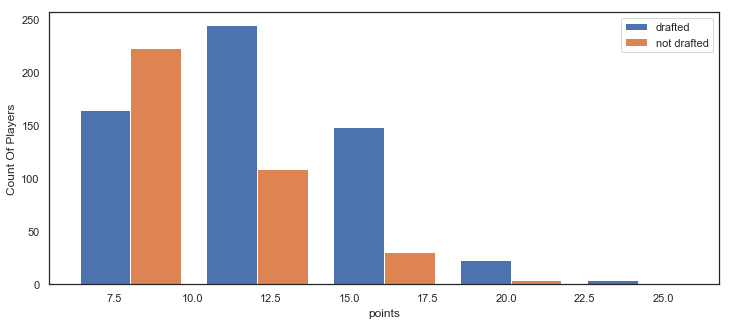

In [423]:
fig, axes = plt.subplots(figsize = (12,5))
labels = ['drafted', 'not drafted']
x = [drafted_players, n_drafted_players]
axes.hist(x, bins = 5, histtype='bar', stacked= False, label = labels)
plt.legend(labels)
plt.xlabel('points')
plt.ylabel('Count Of Players')
plt.show()

In [ ]:
drafted_players = drafted[(drafted['games_played'] >= 58) &(drafted['games_started'] > 35)\
                    & (drafted['weight'] < 204)]['games_played']
n_drafted_players = sampled_n_drafted[(sampled_n_drafted['games_played'] >= 58) & (sampled_n_drafted['games_started'] > 35)\
                & (sampled_n_drafted['weight'] < 204)]['games_played']

In [ ]:
fig, axes = plt.subplots(figsize = (12,5))
labels = ['drafted', 'not drafted']
x = [drafted_players, n_drafted_players]
axes.hist(x, bins = 10, histtype='bar', stacked= False, label = labels)
plt.legend(labels)
plt.xlabel('height')
plt.ylabel('games played')
plt.show()

In [287]:
def plot_feature_importance(model, x_train, n=27):
    # extract and sort the feature importance
    features = model.feature_importances_
    feature_names = x_train.columns.values
    
    # combine the features importance and column names into a matrix and sort them
    feature_matrix = np.array([features, feature_names])
    feature_matrix = feature_matrix.transpose()
    feature_matrix.sort(0)
    
    # divide the column names and feature importance
    sorted_feat = feature_matrix[:, 0]
    sorted_columns = feature_matrix[:, 1]
    
     # plot the features
    plt.figure(figsize=(16, 12))
    try:
        plt.barh(sorted_columns[-n:], sorted_feat[-n:], align='center')
    
    except:
        # if n features is greater than the amount that actually exists
        n = len(sorted_feat)
        plt.barh(sorted_columns[-n:], sorted_feat[-n:], align='center')
        
    plt.yticks(sorted_columns[-n:], sorted_columns[-n:])
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature")
    return

In [290]:
dt_clf = DecisionTreeClassifier()

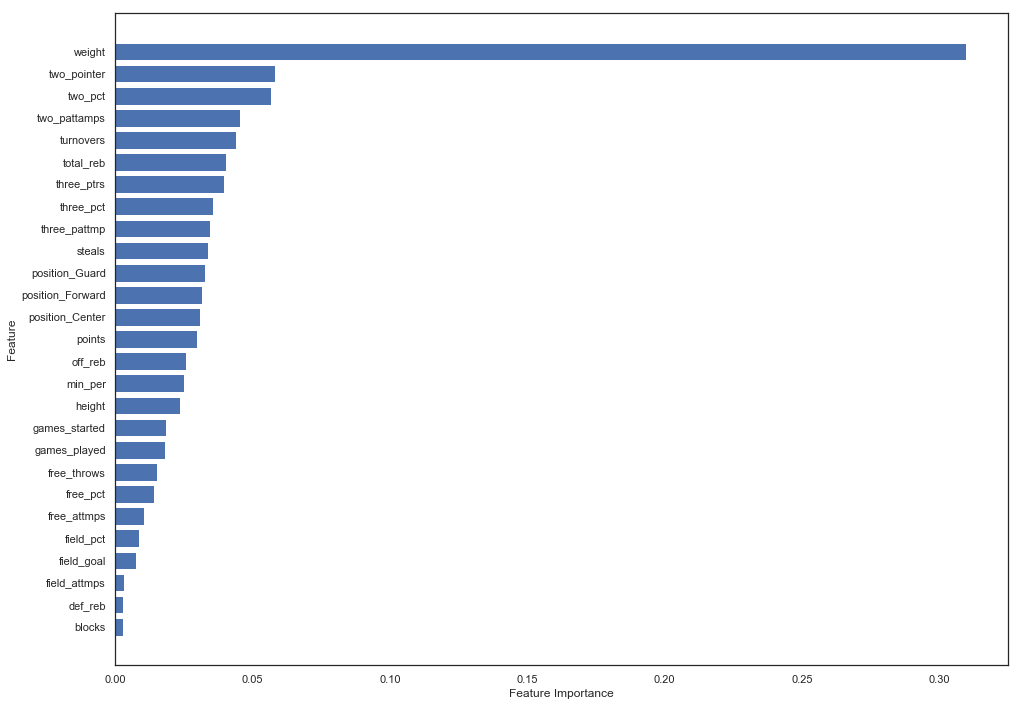

In [291]:
plot_feature_importance(dt_clf.fit(X_train, y_train), X_train)

In [416]:
## adaboost
ada_clf = AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth = 5))

NameError: name 'AdaBoostClassifier' is not defined

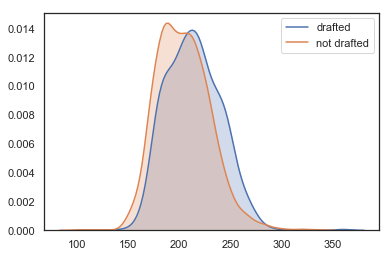

In [300]:
sns.kdeplot(college_nba[['weight', 'drafted']][college_nba['drafted'] == 1]['weight'], shade = True, label="drafted")
sns.kdeplot(college_nba[['weight', 'drafted']][college_nba['drafted'] == 0]['weight'], shade = True, label="not drafted")

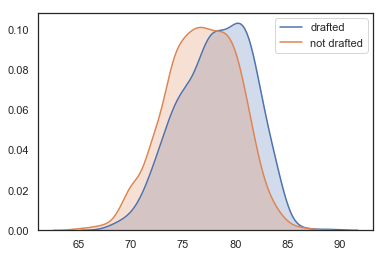

In [424]:
sns.kdeplot(college_nba[['height','weight', 'drafted']][college_nba['drafted'] == 1]['height'], shade = True, label="drafted")
sns.kdeplot(college_nba[['height','weight' ,'drafted']][college_nba['drafted'] == 0]['height'], shade = True, label="not drafted")

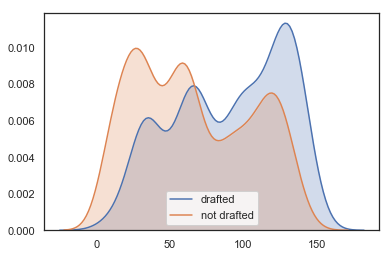

In [303]:
sns.kdeplot(college_nba[['games_played', 'drafted']][college_nba['drafted'] == 1]['games_played'], shade = True, label="drafted")
sns.kdeplot(college_nba[['games_played', 'drafted']][college_nba['drafted'] == 0]['games_played'], shade = True, label="not drafted")

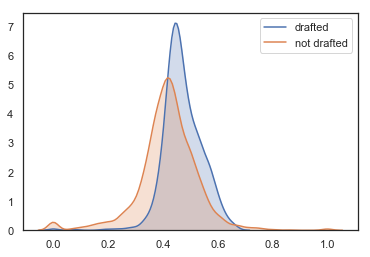

In [304]:
sns.kdeplot(college_nba[['field_pct', 'drafted']][college_nba['drafted'] == 1]['field_pct'], shade = True, label="drafted")
sns.kdeplot(college_nba[['field_pct', 'drafted']][college_nba['drafted'] == 0]['field_pct'], shade = True, label="not drafted")


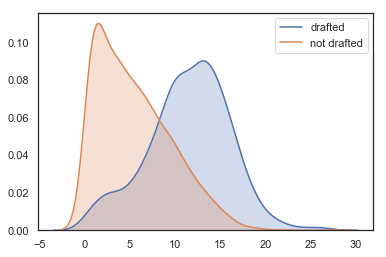

In [415]:
sns.kdeplot(college_nba[['points', 'drafted']][college_nba['drafted'] == 1]['points'], shade = True, label="drafted")
sns.kdeplot(college_nba[['points', 'drafted']][college_nba['drafted'] == 0]['points'], shade = True, label="not drafted")
